Source to following code: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
<br>
Second source is: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#a = [0.784343, 0.637263266326]
#a = np.array(a)
#a = np.around(a,1)
#print(a)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.layers import BatchNormalization


from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2

import math
import os
import random

In [5]:
tf.random.set_seed(1)

In [6]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/X.pickle","rb")
# Remove binary version
X = pickle.load(pickle_in)

pickle_in = open(path+"/y_speed.pickle","rb")
# Remove binary version
y_speed = pickle.load(pickle_in)

pickle_in = open(path+"/y_angle.pickle","rb")
# Remove binary version
y_angle = pickle.load(pickle_in)

pickle_in = open(path+"/image_id.pickle","rb")
# Remove binary version
imageId = pickle.load(pickle_in)
imageId = np.array(imageId)

In [7]:
len(X)

13793

In [8]:
(unique, counts) = np.unique(y_angle, return_counts=True)

In [9]:
def smallerDatasetCreation(image_array,anlge_array,unique_angle, maximumNumberOfImagesForAnyAngle, id_array, speed_array):
  index = np.where(anlge_array == unique_angle)
  idOfImages = id_array[index]
  speed = speed_array[index]

  image_array_new = image_array[index,:,:,:]
  image_array_new = image_array_new.reshape(image_array_new.shape[1],image_array_new.shape[2],image_array_new.shape[3],image_array_new.shape[4])
  #print(image_array_new.shape)
  if image_array_new.shape[0] > maximumNumberOfImagesForAnyAngle: # If more than X pictures exist for the specific angle then:
    # Shuffle images
    #image_array_new,idOfImages,speed = shuffle(image_array_new,idOfImages,speed)
    #image_array_new,idOfImages,speed = shuffle(image_array_new,idOfImages,speed)

    image_array_new = image_array_new[0:maximumNumberOfImagesForAnyAngle,:,:,:]
    idOfImages = idOfImages[0:maximumNumberOfImagesForAnyAngle]
    speed = speed[0:maximumNumberOfImagesForAnyAngle]
    #print(image_array_new.shape)
  return(image_array_new, idOfImages,speed)

In [10]:
X_new = []
y_angle_new = []
y_speed_new = []
idImage = []
totalNumberOfImages = 0
maxNumberOfImages = 700

for uniqueAngle in unique:
    X_reduced, id, speed = smallerDatasetCreation(X,y_angle,uniqueAngle,maxNumberOfImages, imageId, y_speed)
    totalNumberOfImages = totalNumberOfImages + X_reduced.shape[0]

    print(totalNumberOfImages)
    #print(X_reduced.shape[0])
    X_new.extend(X_reduced)
    idImage.extend(id)
    y_speed_new.extend(speed)
    y_angle_new.extend(np.ones(X_reduced.shape[0]) * uniqueAngle)

60
88
187
285
389
602
1030
1730
2430
3130
3830
4530
5230
5930
6231
6296
6331


Turn the images to grayscale

In [11]:
X_gray =[]
for img in X_new:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  X_gray.append(img)

In [12]:
X_new = X_gray

In [13]:
X = [] # release ram

In [14]:
print(len(X_new))
print(len(y_speed_new))
print(len(y_angle_new))
print(len(idImage))

6331
6331
6331
6331


In [15]:
X_new = np.array(X_new)
y_angle_new = np.array(y_angle_new)
y_speed_new = np.array(y_speed_new)
idImage = np.array(idImage)

if len(X_new.shape) == 3:
  X_new = tf.reshape(X_new,[ X_new.shape[0],X_new.shape[1],X_new.shape[2] ,1 ]).numpy()
else:
  X_new = tf.reshape(X_train,[ X_new.shape[0],X_new.shape[1],X_new.shape[2] ,3 ]).numpy()

print(X_new.shape)
print(y_angle_new.shape)
print(y_speed_new.shape)
print(idImage.shape)

(6331, 240, 320, 1)
(6331,)
(6331,)
(6331,)


5754
1.0


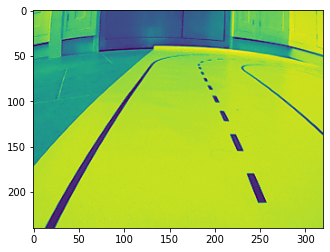

In [16]:
show = 2389
plt.imshow(X_new[show,:,:,0])
print(idImage[show])
print(y_speed_new[show])

<function matplotlib.pyplot.show>

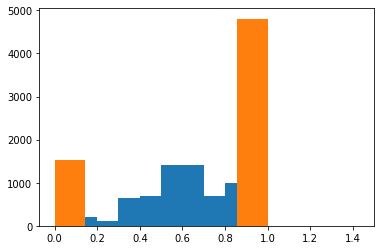

In [17]:
plt.hist(y_angle_new)
plt.show
plt.hist(y_speed_new)
plt.show

In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
indxKeepSpeedOne = np.where(y_speed_new == 0)
#print(indxKeepSpeedOne[0])
#print(y_speed_new[indxKeepSpeedOne[0]] )
#print(images.shape)

Keep specific images of speed 1 to ensure that speed 1 and speed 0 have about the same data?

In [20]:
indxKeepSpeedOne = np.where(y_speed_new == 0)
# brightness_range = (0.3, 0.7),
image_generator = ImageDataGenerator(width_shift_range = 0.2,height_shift_range=0.2,horizontal_flip=True,fill_mode='nearest') 
count = 0
print(len(X_new[indxKeepSpeedOne[0]]))
channels =1
createdImages = []
#for img in X_new[indxKeepSpeedOne[0]]:

images = X_new[indxKeepSpeedOne[0],:,:,0]

images = tf.reshape(images,[images.shape[0],images.shape[1],images.shape[2],1]).numpy()
#print(img.shape)
#break
#generatedImages =  image_generator.flow(img, batch_size=1)
data_gen =  image_generator.flow(images, batch_size=1)
#createdImages.extend(generatedImages)
#plotImages(generatedImages)
# indxKeepSpeedZero = np.where(y_speed_new == 0)
# #print(indxRemoveSpeedOne[0])
# randomImagesToKeep = random.choices(indxKeepSpeedOne[0], k = 2000)
# #print(randomImagesToKeep)
# #print(indxKeepSpeedZero[0])
# indxToKeep = list(indxKeepSpeedZero[0]) + list(randomImagesToKeep)

# y_speed_new = y_speed_new[indxToKeep]
# X_new = X_new[indxToKeep]
# y_angle_new = y_angle_new[indxToKeep]
# idImage = idImage[indxToKeep]

1524


In [21]:
print(len(data_gen[2][0]))
print(len(data_gen))
print(len(range(5)))

240
1524
5


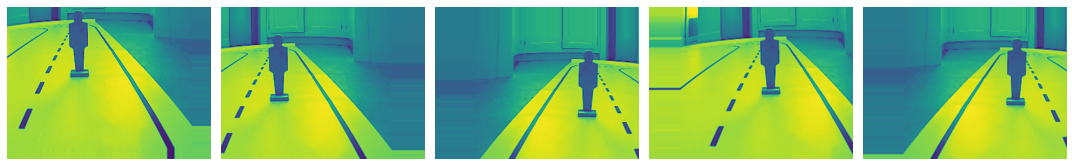

In [82]:
augmented_images = [data_gen[3][0] for i in range(5)]
plotImages(augmented_images)

In [23]:
augmented_images = [[data_gen[66][0],1] for i in range(5)]

In [24]:
#print(augmented_images[0])

keep two images from each data augmentation created

In [25]:
generatedImages = []
speedOfInterest = 0
for i in range(len(data_gen)):
  augmented_images = [[data_gen[i][0],speedOfInterest] for i in range(3)]
  generatedImages.extend(augmented_images)

In [26]:
#print(generatedImages[0])
img, s = generatedImages[0]
print(img.shape)

(240, 320, 1)


In [27]:
#print(X_new[0])

In [28]:
y_s = []
images = []
images.extend(X_new)
y_s.extend(y_speed_new)
#print(y_s)
for img, speed in generatedImages:
  #img = np.array(img)
  img = tf.reshape(img,[1,img.shape[0],img.shape[1],img.shape[2]]).numpy()
  #print(img[0][0].shape)
  images.extend(img)
  y_s.append(speed)

In [29]:
print(len(images))
print(len(y_s))

10903
10903


In [30]:
X_new = np.array(images)
y_speed_new = np.array(y_s)
print(X_new.shape)
#print(y_angle_new.shape)
print(y_speed_new.shape)
#print(idImage.shape)

(10903, 240, 320, 1)
(10903,)


<function matplotlib.pyplot.show>

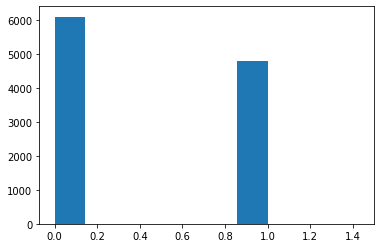

In [31]:
plt.hist(y_speed_new)
plt.show

speed 0.0


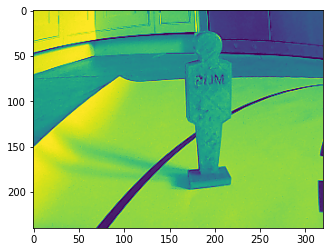

In [32]:
show = 5000
plt.imshow(X_new[show,:,:,0])
#print("angle",y_angle_new[show])
print("speed",y_speed_new[show])
#print(idImage[show])

Preprocces images to scale, normalize change RGB to YUV and add gaussian noise

In [33]:
def img_preprocess(image, speed = True):
    height, _, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    if speed == False:
      image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
      image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    else:
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = image
    #image = cv2.Canny(image, 200, 400)
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    
    #image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    
    return image

In [34]:
X_final = []
for img_index in range(X_new.shape[0] ):
  X_f = img_preprocess(X_new[img_index,:,:,:])
  X_final.append(X_f)
  #print(img_index)

In [35]:
X_new = []

In [36]:
X_final = np.array(X_final)
#X_final = np.array(X_final, dtype=np.float16)
print(X_final.shape)
print(len(X_final.shape))

(10903, 240, 320)
3


speed 0.0


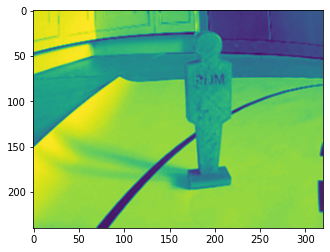

In [37]:
show = 5000
plt.imshow(X_final[show,:,:])

print("speed",y_speed_new[show])


In [38]:
for i in range(y_speed_new.shape[0]):
  if y_speed_new[i]>1:
    y_speed_new[i] = 1

Create a test dataset to ensure that we do not overfit

In [39]:
index = range(X_final.shape[0])
#print(index[0:20])
index_train, index_test = train_test_split( index, test_size=0.1, shuffle=True)
print(index_train[0:10])

[4879, 2089, 479, 10553, 8522, 3654, 1228, 4153, 375, 3057]


In [40]:
X_train = X_final[index_train,:,:]
X_test= X_final[index_test,:,:]

#y_train_a= y_angle_new[index_train]
#y_test_a = y_angle_new[index_test]

y_train_s= y_speed_new[index_train]
y_test_s = y_speed_new[index_test]

#idImage_train = idImage[index_train]
#idImage_test = idImage[index_test]

[1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1.]


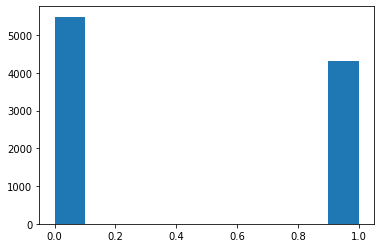

In [41]:
plt.hist(y_train_s)
plt.show
print(y_train_s[1:60])

<function matplotlib.pyplot.show>

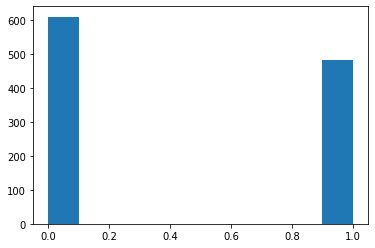

In [42]:
plt.hist(y_test_s)
plt.show

In [43]:
# This is to realease some RAM
X_final = []

0.0


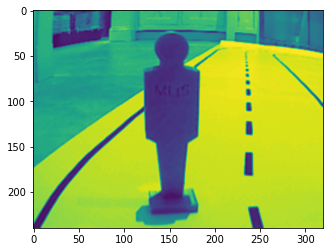

In [44]:
show = 6
plt.imshow(X_train[show,:,:])
#print(y_train_a[show])
print(y_train_s[show])
#print(idImage_train[show])

In [45]:
print(X_train.shape)
#tf_y_train = tf.reshape(y_train_a,[ y_train_a.shape[0] ,1 ]).numpy()
tf_y_train = tf.reshape(y_train_s,[ y_train_s.shape[0] ,1 ]).numpy()
print(y_train_s.shape)
print(tf_y_train.shape)
if len(X_train.shape) == 3:
  #X_train = tf.reshape(X_train,[ X_train.shape[0],X_train.shape[1],X_train.shape[2] ,1 ]).numpy()
  X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2] ,1 ) )
  #X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
else:
  X_train = tf.reshape(X_train,[ X_train.shape[0],X_train.shape[1],X_train.shape[2] ,3 ]).numpy()
print(X_train.shape)
X_test = tf.reshape(X_test,[ X_test.shape[0],X_test.shape[1],X_test.shape[2] ,X_train.shape[3] ]).numpy()

(9812, 240, 320)
(9812,)
(9812, 1)
(9812, 240, 320, 1)


In [46]:
def nvidia_model_speed():
    model = Sequential(name='Nvidia_Model_speed')
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]), activation='elu')) 
    #model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(120, 320, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    #model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    #model.add(MaxPooling2D())
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(MaxPooling2D())
    # not part of NVidia
    #model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    #model.add(Dropout(0.2))
    #model.add(Dense(200, activation='elu')) # NOT PART OF NVIDIA
    #model.add(Dense(200, activation='elu'))

    model.add(Dropout(0.1)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    #model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='elu'))
    #model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.05))
    #model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1,activation = 'sigmoid') )
    
    #classification problem,
  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = nvidia_model_speed()
print(model.summary())

Model: "Nvidia_Model_speed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 158, 24)      624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 36)        21636     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 38, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 17, 48)        43248     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 6, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 4, 64)   

Source for the following resent: https://towardsdatascience.com/how-to-train-your-self-driving-car-using-deep-learning-ce8ff76119cb

In [47]:
# from keras.applications import ResNet50
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]))

# for layer in resnet.layers[:-4]:
#     layer.trainable = False
 
# for layer in resnet.layers:
#     print(layer, layer.trainable)

In [48]:
# def nvidia_model():
#   model = Sequential()
#   model.add(resnet)
#   model.add(Dropout(0.5))
#   model.add(Flatten())
#   model.add(Dense(100, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(50, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(10, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(1))
#   optimizer = Adam(lr=1e-3)
#   model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
#   return model

# model = nvidia_model()
# print(model.summary())

In [49]:
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
#         patience=7, verbose=1, mode='auto',
#         restore_best_weights=True)
monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, 
         patience=7, verbose=1, mode='auto',
         restore_best_weights=True)
model.fit(X_train, tf_y_train, batch_size=64, epochs=100, validation_split=0.2,callbacks=[monitor])
#model.fit(X_train, tf_y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
123/123 [==============================] - 37s 45ms/step - loss: 0.5361 - accuracy: 0.7095 - val_loss: 0.2105 - val_accuracy: 0.9282
Epoch 2/100
123/123 [==============================] - 5s 38ms/step - loss: 0.1765 - accuracy: 0.9411 - val_loss: 0.1294 - val_accuracy: 0.9592
Epoch 3/100
123/123 [==============================] - 5s 38ms/step - loss: 0.1140 - accuracy: 0.9615 - val_loss: 0.1124 - val_accuracy: 0.9654
Epoch 4/100
123/123 [==============================] - 5s 38ms/step - loss: 0.0975 - accuracy: 0.9675 - val_loss: 0.1053 - val_accuracy: 0.9684
Epoch 5/100
123/123 [==============================] - 5s 38ms/step - loss: 0.0765 - accuracy: 0.9740 - val_loss: 0.1094 - val_accuracy: 0.9648
Epoch 6/100
123/123 [==============================] - 5s 38ms/step - loss: 0.0737 - accuracy: 0.9744 - val_loss: 0.1069 - val_accuracy: 0.9684
Epoch 7/100
123/123 [==============================] - 5s 38ms/step - loss: 0.0621 - accuracy: 0.9783 - val_loss: 0.0845 - val_accuracy

In [50]:
steering_angle = model.predict(X_test)

In [51]:
gc.collect()

2310

In [52]:
results = []
for i in range(y_test_s.shape[0]):  
  #print([steering_angle[i][0], tf_y_angle[i][0]])
  results.append([steering_angle[i][0], y_test_s[i] ])
  print([steering_angle[i][0], y_test_s[i] ])

[0.9973514, 1.0]
[0.9971629, 1.0]
[0.9996284, 1.0]
[0.99309593, 1.0]
[0.99995327, 1.0]
[2.106916e-20, 0.0]
[0.9965245, 1.0]
[0.9999844, 1.0]
[2.839349e-16, 0.0]
[1.9107544e-13, 0.0]
[0.9997298, 1.0]
[0.99997437, 1.0]
[0.99976856, 1.0]
[7.119556e-14, 0.0]
[5.2664925e-13, 0.0]
[5.793277e-16, 0.0]
[0.99998534, 1.0]
[3.159189e-13, 0.0]
[1.8177413e-16, 0.0]
[0.9999733, 1.0]
[0.99296474, 1.0]
[0.9982595, 1.0]
[0.99122834, 1.0]
[4.5154893e-14, 0.0]
[0.9377907, 0.0]
[8.753183e-13, 0.0]
[6.3486537e-13, 0.0]
[0.9999305, 1.0]
[0.99995697, 1.0]
[1.0632945e-20, 0.0]
[0.9999914, 1.0]
[2.4399795e-17, 0.0]
[9.004985e-12, 0.0]
[2.849906e-07, 0.0]
[0.999705, 1.0]
[0.997413, 1.0]
[0.9995732, 1.0]
[2.2082104e-16, 0.0]
[3.9353605e-08, 0.0]
[0.9998807, 1.0]
[0.99995935, 1.0]
[0.9932539, 1.0]
[8.534837e-06, 0.0]
[2.5966394e-05, 0.0]
[6.411063e-14, 0.0]
[0.99866176, 1.0]
[0.99010897, 1.0]
[0.99997735, 1.0]
[0.99999857, 1.0]
[1.26573846e-17, 0.0]
[0.9859461, 1.0]
[0.9930735, 1.0]
[0.9998995, 1.0]
[2.644971e-15

In [53]:
newResults = []
count = 0 
for value,actualValue in results:
  if value >= 0.5:
    value = 1
  else:
    value =0
  newResults.append([value,actualValue])
  count += 1
print(newResults)

[[1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0],

In [54]:
print(X_test.shape)

(1091, 240, 320, 1)


Count Misclassifications

In [80]:
countMisclasified = 0
count = 0 
for value,actualValue in newResults:
  if value != actualValue:
    #print(id)
    print("value found",value, "Actual value",actualValue)
    plt.imshow(X_test[count,:,:,0] ) 
    plt.show()
    countMisclasified +=1
  count += 1
print("misclassified objects",countMisclasified)
print("total number of test data", y_test_s.shape[0])
print("misclassification ratio",count/y_test_s.shape[0])

Output hidden; open in https://colab.research.google.com to view.

Calculate the Mean squared error

In [56]:
mseSum = 0
print(y_test_s.shape[0])
for i in range(y_test_s.shape[0]):
  mseSum += (1/y_test_s.shape[0] ) *  (steering_angle[i][0] - y_test_s[i])**2
print(mseSum)

1091
0.03008124099502148


In [57]:
mseSum = 0
print(y_test_s.shape[0])
for a,b in newResults:
  mseSum += (1/y_test_s.shape[0] ) *  (a - b)**2
print(mseSum)

1091
0.034830430797433566


In [58]:
del model

In [59]:
#model.save(os.path.join(path,'Speed_prediction_model.h5'))

In [60]:
#path = "/content/drive/My Drive/AutonomousDriving"
#model = load_model(path+'/Speed_prediction_model.h5')

In [61]:
#import pickle

#path = "/content/drive/My Drive/AutonomousDriving"
#pickle_in = open(path+"/testColourImages.pickle","rb")
# Remove binary version
#test = pickle.load(pickle_in)

In [62]:
#print(test.shape[0])
#plt.imshow(test[20])

In [63]:
# def img_preprocess(image, speed = True):
#     height, _, _ = image.shape

#     # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
#     if speed == False:
#       image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)  # Nvidia model said it is best to use YUV color space
#     else:
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     #image = cv2.Canny(image, 200, 400)
    
    
#     #image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
#     image = image / 255 # normalizing
#     # Round everything into the image to 1 decimal place
#     image = np.around(image ,2)
    
#     return image

In [64]:
# X_final = []
# for img_index in range(test.shape[0]):
#   X_f = img_preprocess(test[img_index,:,:,:])
#   X_final.append(X_f)

In [65]:
#X_final = np.array(X_final)

In [66]:
#print(X_final.shape)

In [67]:
# X_final = np.reshape(X_final, (X_final.shape[0],X_final.shape[1],X_final.shape[2] ,1 ) )
# print(X_final.shape)

In [68]:
#speedPredictions = model.predict(X_final)

In [69]:
# results = []
# for i in range(test.shape[0]):  
#   results.append(speedPredictions[i][0])
#   print(speedPredictions[i][0])

In [70]:
# newResults = []
# count = 0 
# for value in results:
#   if value >= 0.5:
#     value = 1
#   else:
#     value =0
#   newResults.append(value)
#   count += 1
# print(newResults)
# print(count)

Export results to a csv file

In [71]:
# import csv

# with open('/content/drive/My Drive/AutonomousDriving/speed.csv','w') as ff:
#   write = csv.writer(ff)
#   write.writerow(newResults)

In [72]:
#model = load_model(path+'/Angle_prediction_model.h5')

Now save the model output

In [73]:
#import os
# always save model output as soon as model finishes training
#model.save(os.path.join(path,'angle_prediction.h5'))

In [74]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(32))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.fit(X, y_speed, batch_size=32, epochs=2, validation_split=0.8)

Run the same model as above for angle prediction but change the loss function since we do not have classification. ALso accuracy is not a term to measure.

In [75]:
#y_angle

In [76]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='mean_squared_error',
#               optimizer='adam')

# model.fit(X, y_angle, batch_size=32, epochs=2, validation_split=0.95)